In [17]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import util, SentenceTransformer
import fitz
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import random

device = 'mps'

In [18]:
emb_chunks_df = pd.read_csv('emb_chunks_df.csv')
emb_chunks_df.head()

,page_n,sentence_chunk,chunk_chars,chunk_words,chunk_tokens,embedding
0,0,Personal Banking Terms and Conditions and Bank...,137,22,34.25,"[-0.0019956764299422503, -0.03843894228339195,..."
1,1,2 This booklet: • Explains the agreement betwe...,380,77,95.00,"[0.048675764352083206, -0.03856918588280678, -..."
2,2,3 Section A – Our agreement When you open a cu...,2307,391,576.75,"[0.023868504911661148, -0.09681934118270874, 0..."
3,2,You must not hold money for someone else in yo...,1920,348,480.00,"[0.014817321673035622, -0.055876679718494415, ..."
4,3,4 Where to find what you want to know Section ...,3033,531,758.25,"[0.033143796026706696, -0.0936892107129097, -0..."


In [19]:
# convert embeddings back to np.array
emb_chunks_df['embedding'] = emb_chunks_df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=', '))
embs = torch.tensor(np.stack(emb_chunks_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)

pages_n_chunks = emb_chunks_df.to_dict(orient='records')

emb_chunks_df.head()

,page_n,sentence_chunk,chunk_chars,chunk_words,chunk_tokens,embedding
0,0,Personal Banking Terms and Conditions and Bank...,137,22,34.25,"[-0.0019956764299422503, -0.03843894228339195,..."
1,1,2 This booklet: • Explains the agreement betwe...,380,77,95.00,"[0.048675764352083206, -0.03856918588280678, -..."
2,2,3 Section A – Our agreement When you open a cu...,2307,391,576.75,"[0.023868504911661148, -0.09681934118270874, 0..."
3,2,You must not hold money for someone else in yo...,1920,348,480.00,"[0.014817321673035622, -0.055876679718494415, ..."
4,3,4 Where to find what you want to know Section ...,3033,531,758.25,"[0.033143796026706696, -0.0936892107129097, -0..."


In [20]:
embs.shape, embs

(torch.Size([66, 768]),
 tensor([[-0.0020, -0.0384,  0.0048,  ...,  0.0263, -0.0511,  0.0013],
         [ 0.0487, -0.0386, -0.0102,  ...,  0.0025, -0.0138, -0.0413],
         [ 0.0239, -0.0968,  0.0073,  ...,  0.0380, -0.0420,  0.0084],
         ...,
         [-0.0057,  0.0289, -0.0245,  ...,  0.0407, -0.0547,  0.0007],
         [-0.0331, -0.0685, -0.0053,  ...,  0.0332, -0.0491,  0.0223],
         [-0.0027, -0.0738,  0.0023,  ...,  0.0029, -0.0616, -0.0040]],
        device='mps:0'))

In [21]:
emb_model = SentenceTransformer('all-mpnet-base-v2', device=device)
# mixedbread-ai/mxbai-embed-large-v1

In [22]:
query = 'electronic payments'

query_emb = emb_model.encode(query, convert_to_tensor=True).to(device)

scores = util.cos_sim(a=query_emb, b=embs)[0]

top_results = torch.topk(scores, k=5)

print(f'*** Query: {query} ***\n')
for score, idx in zip(top_results[0], top_results[1]):
    print(f'Score: {score:.4f}')
    print(f'Text: {pages_n_chunks[idx]["sentence_chunk"]}')
    print(f'Page number: {pages_n_chunks[idx]["page_n"]}\n')


*** Query: electronic payments ***

Score: 0.4689
Text: If you use a mobile payment method, we may ask for other information like a name or mobile number. When you are setting up a new payment arrangement, we'll need to know if the payment is going to a personal  or business account. We will also ask for the full name of the person you're paying. If you send money outside the UK or in a foreign currency to a bank in the European Payments Area (SEPA), we'll need: • the full name and address of the person you are paying; • the name and address of their bank; • the international bank account number (IBAN); • the bank identifier code (BIC) The information we need for other types of foreign payments will depend on the type of payment and the country  you want to send it to. You must check the details you give us are correct before you ask us to make a payment. If the person you are paying has switched their account to another bank using the Current Account Switch Service, we will use their 

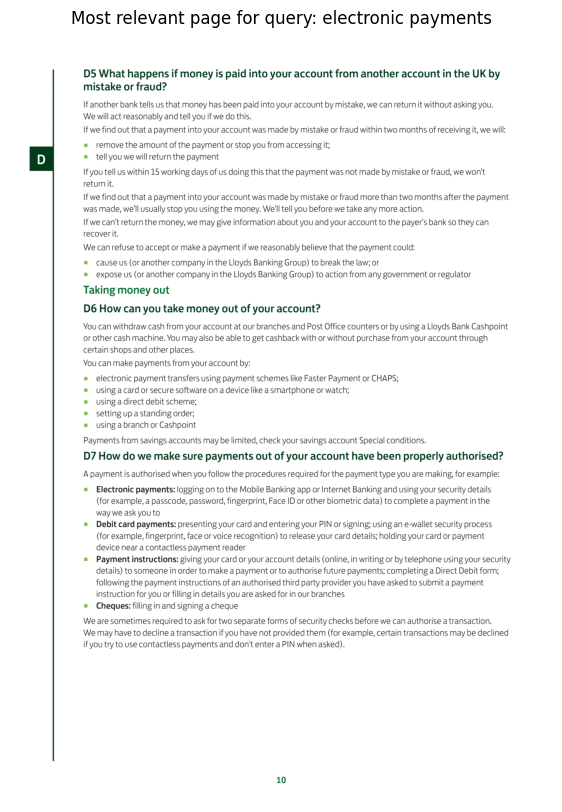

In [23]:
pdf_path = 'lloyds_personal_t_n_c.pdf'
doc = fitz.open(pdf_path)
page = doc.load_page(9)

img = page.get_pixmap(dpi=300)
doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f'Most relevant page for query: {query}')
plt.axis('off')
plt.show()

In [24]:
def retrieve_relevant_info(query: str, embeddings: torch.tensor, model: SentenceTransformer=emb_model, n_to_retrieve: int=5) -> torch.tensor:
    query_emb = model.encode(query, convert_to_tensor=True)
    dot_scores = util.cos_sim(query_emb, embeddings)[0]
    scores, indices = torch.topk(dot_scores, n_to_retrieve)
    print(scores)
    return scores, indices

def print_topk(query: str, embeddings: torch.tensor, pages_n_chunks: list[dict]=pages_n_chunks, n_to_retrieve: int=5):
    scores, indices = retrieve_relevant_info(query, embeddings)

    print(f'--- Query: {query} ---')
    for score, idx in zip(scores, indices):
        print(f'Score: {score:.4f}')
        print(f'Text: {pages_n_chunks[idx]["sentence_chunk"]}')
        print(f'Page number: {pages_n_chunks[idx]["page_n"]}\n')

In [25]:
query = 'exchange rates abroad'
print_topk(query,embs)

tensor([0.5785, 0.5662, 0.4936, 0.4691, 0.4098], device='mps:0')
--- Query: exchange rates abroad ---
Score: 0.5785
Text: The provider of the foreign currency may make a separate charge for conversion. We won't charge a foreign currency cash fee or a foreign cash fee if you withdraw Euro within the EEA or UK. Buying goods or services in a foreign currency If you use your debit card to: • make a purchase or other transaction (not a cash withdrawal) in a foreign currency, the card payment scheme, for example, Visa, will convert the amount into pounds the day the transaction is processed using their exchange rate. In Visa's case, this will be the Visa Payment Scheme Exchange Rate. The symbol on your card will tell you which payment scheme applies. You can check the payment scheme exchange rate for your card online  at: lloydsbank.com/travel/using-debit-credit-cards-abroad We will charge you a foreign currency transaction fee of 2.99% of the value in pounds of the transaction. This is a fe

In [26]:
model_id = 'google/gemma-2b-it'

tokenizer = AutoTokenizer.from_pretrained(model_id)
llm_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, low_cpu_mem_usage=False, attn_implementation='sdpa').to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
queries = [
    'How does overdraft work?',
    'In what cases may I close my account?',
    'How can I make international payments?',
    'What are the fees for current accounts?',
    'How can I open a joint account?',
    'How can I keep my account safe?',
    'What happens if someone hacked my account?',
    'Are there restrictions when opening an account?',
    'Are there restrictions when making international payments?'
]

In [28]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    context = '- ' + '\n- '.join([item['sentence_chunk'] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style, but don't use the below example answers as answers to the query.
\nExample 1:
Query: What are the conditions for opening a savings account?
Answer: You must be at least 18 years old. You need to provide valid identification documents such as a passport or driver's license. There may be a minimum deposit requirement, which varies depending on the type of savings account. You must agree to abide by the terms and conditions outlined in the account agreement. You may need to provide proof of address, such as a utility bill or rental agreement.
\nExample 2:
Query: What are the penalties for overdrawing on a checking account?
Answer: Overdrawing on a checking account may result in overdraft fees charged by the bank. These fees vary depending on the bank's policy and the amount overdrawn. Additionally, continued overdrawing may lead to the closure of the account or other consequences as outlined in the bank's terms and conditions.
\nExample 3:
Query: Can I transfer funds between different accounts within the bank?
Answer: Yes, you can typically transfer funds between different accounts held within the same bank. This can usually be done through online banking, mobile banking, ATMs, or by visiting a branch. However, there may be limits on the number of transfers allowed per month, and certain types of accounts may have restrictions or fees associated with transfers.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    base_prompt = base_prompt.format(context=context, query=query)
    
    # make sure the inputs to the model are in the same way that they have been trained
    dialogue_template = [
        {
            'role': 'user',
            'content': base_prompt
        }
    ]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)

    return prompt

In [29]:
def ask(qeury: str, temperature: float=0.2, max_new_tokens: int=256, format_answer_text: bool=True, return_context: bool=False):
    # -------- RETRIEVAL --------
    scores, indices = retrieve_relevant_info(query, embs)
    context_items = [pages_n_chunks[i] for i in indices]
    for i, item in enumerate(context_items):
        item['score'] = scores[i].cpu()

    # -------- AUGMENTATION --------
    prompt = prompt_formatter(query, context_items)

    # -------- GENERATION --------
    input_ids = tokenizer(prompt, return_tensors='pt').to(device)
    outputs = llm_model.generate(**input_ids, temperature=temperature, do_sample=True, max_new_tokens=max_new_tokens)
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')

    if not return_context:
        return output_text
    
    return output_text, context_items

In [33]:
query = 'What are the fees for current accounts?' # random.choice(queries)
print(f'Query: {query}')
ask(query, temperature=0.7, return_context=False)

Query: What are the fees for current accounts?
tensor([0.5758, 0.5725, 0.5540, 0.5386, 0.5344], device='mps:0')


"Sure, here is the answer to the user's query:\n\nThe passage provides information about the monthly maintaining the account fee for various account types, including Classic Account, Under 19s Account, Student Account, Graduate Account, Basic Account, Cash Account (not offered to new customers), Islamic Account (not offered to new customers), and Club Lloyds and Added Value Accounts.\n\n* **Classic Account:** Monthly maintaining the account fee is £3.\n* **Under 19s Account:** Monthly maintaining the account fee is £9.\n* **Student Account:** Monthly maintaining the account fee is £11 - 17.\n* **Graduate Account:** Monthly maintaining the account fee is not mentioned in the context.\n* **Basic Account:** Monthly maintaining the account fee is £3.\n* **Cash Account:** Monthly maintaining the account fee is not mentioned in the context.\n* **Islamic Account:** Monthly maintaining the account fee is not mentioned in the context.\n* **Club Lloyds Account:** The monthly maintaining the acco

In [31]:
torch.mps.empty_cache()